# Getting Started
Let's begin by getting familiar with some of the relevant algorithms and datasets that we could use in the paper.
- [ ] Find several classic timeseries datasets: sunspots, stock prices, streamflow from the Mississippi River would all be fine, but bonus points if you find (or simulate) something more humerous.
- [ ] Try out several seasonal trend decompositions: STL, STR as example
- [ ] Try out fft and clipping out different `bands` from the frequency domain
- [ ] Put those pieces together to define a function for STF: seasonal-trend decomposition using the Fast-Fourier transform.

Good luck!

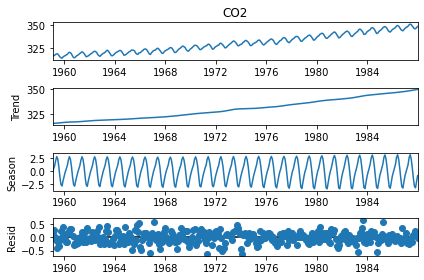

In [142]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

co2 =pd.read_csv('../data/co2.csv', index_col='date', parse_dates=True, squeeze=True)

stl = STL(co2, seasonal=13)
res = stl.fit()
fig = res.plot()

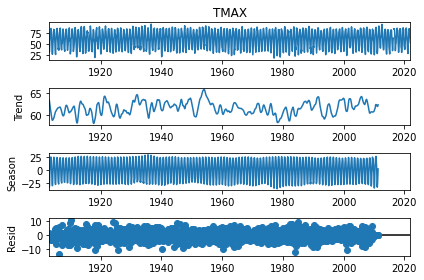

In [143]:
# Load in daily temperature data from station USC00118740
champaignTemp = pd.read_csv('../data/champaign_temps.csv', index_col='date', parse_dates=True, squeeze=True)

# Aggregate to find average max and min temperatures by month
champaignTemp = champaignTemp.resample('M').mean()

# STL on TMAX
stl = STL(champaignTemp["TMAX"])
res = stl.fit()
fig = res.plot()

import warnings
warnings.filterwarnings("ignore")

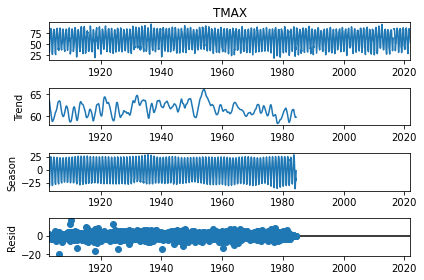

In [144]:
# STL on TMAX with robust = True
stl = STL(champaignTemp["TMAX"], robust = True)
res = stl.fit()
fig = res.plot()

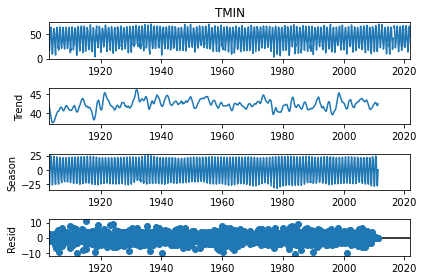

In [145]:
# STL on TMIN
stl = STL(champaignTemp["TMIN"])
res = stl.fit()
fig = res.plot()

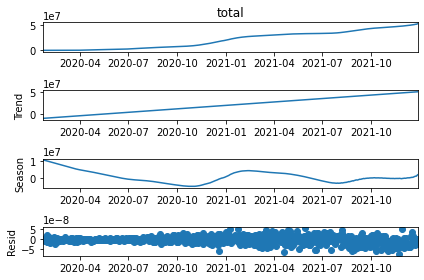

In [146]:
# STL on covid dataset

# Data cleaning
covid = pd.read_csv('../data/time_series_covid19_confirmed_US.csv', parse_dates=True, squeeze=True)
covid_dates = covid.iloc[:, 11:]
covid_dates = covid_dates.T
covid_dates["total"] = covid_dates.sum(axis=1)
covid_dates.index = pd.to_datetime(covid_dates.index, format = '%m/%d/%y')

stl = STL(covid_dates["total"], period = 365)
res = stl.fit()
fig = res.plot()




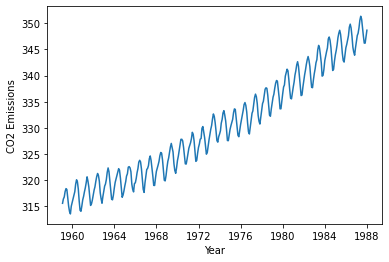

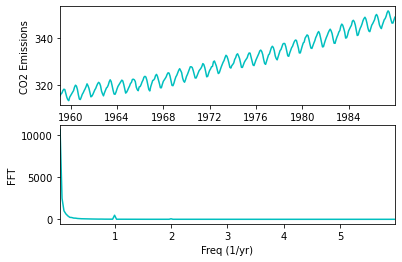

In [192]:
# Tring fft on co2 data
import matplotlib.pyplot as plt
import matplotlib.dates
from datetime import datetime
import statistics
from scipy import signal

co2 = pd.read_csv("../data/co2.csv")

co2["date"] = pd.to_datetime(co2["date"], format = '%Y-%m-%d')
#co2["CO2"] = (co2["CO2"] - statistics.median(co2["CO2"])) * signal.tukey(len(co2))

dt = 1 / 12 # yearly freq
t = np.array(co2["date"])
f = np.array(co2["CO2"])
plt.plot(t, f)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")


n = len(t)
#Compute FFT
fhat = np.fft.fft(f, n)
# Power Spectrum
PSD = fhat * np.conj(fhat) / n
# X axis of freqs
freq = (1 / (dt*n)) * np.arange(n)

# Plotting first half
L = np.arange(1, np.floor(n/2), dtype = 'int')

fig, axes = plt.subplots(2, 1)

plt.sca(axes[0])
plt.plot(t, f, color = 'c', LineWidth = 1.5)
plt.xlim(t[0], t[-1])
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.sca(axes[1])
plt.plot(freq[L], PSD[L], color = 'c')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.xlabel("Freq (1/yr)")
plt.ylabel("FFT")
plt.show()


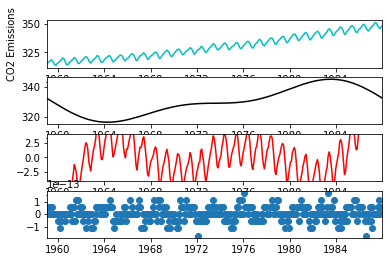

In [193]:
# Use the PSD to filter out noise
# Filter out freqs with low power
peaks = int(np.quantile(PSD, .99))
indices = PSD > peaks

PSDclean = PSD * indices
# Zero out small Fourier coefs
fhat_clean = indices * fhat
# Inverse FFT for filtered time signal
ffilt = np.fft.ifft(fhat_clean)

# Filter out freqs with high power
indices_seasonal = PSD <= peaks
PSD_seasonal = PSD * indices
fhat_seasonal = indices_seasonal * fhat
ffilt_seasonal = np.fft.ifft(fhat_seasonal)


fig, axes = plt.subplots(4, 1)
plt.sca(axes[0])
plt.plot(t, f, color = 'c')
plt.xlim(t[0], t[-1])
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")


plt.sca(axes[1])
plt.plot(t, ffilt, color = 'k')
plt.xlim(t[0], t[-1])


plt.sca(axes[2])
plt.plot(t, ffilt_seasonal, color = "red")
plt.xlim(t[0], t[-1])
plt.ylim(-4, 4)


# Find the residuals 
residuals = co2["CO2"] - ffilt_seasonal - ffilt
plt.sca(axes[3])
plt.scatter(t, residuals)
plt.xlim(t[0], t[-1])

plt.show()

In [181]:
# Initial Statistical Summary
print("The sum of the residuals for STF is ", sum(residuals))
print("The sum of the residuals for STL is ", sum(res.resid))

# The real residual of STF is smaller than the residual for STL
print(abs(sum(residuals).real) < abs(sum(res.resid)))

# Take the dot product of components for STF and STL
print("The dot product of STL seasonal and trend components is ", np.round(res.seasonal.dot(res.trend)))
print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))

The sum of the residuals for STF is  (-3.1171246139827247e-14+3.944304526105059e-31j)
The sum of the residuals for STL is  -1.9713952497113496e-06
True
The dot product of STL seasonal and trend components is  -7674558547661269.0
The dot product of STF seasonal and trend components is  (-0+0j)


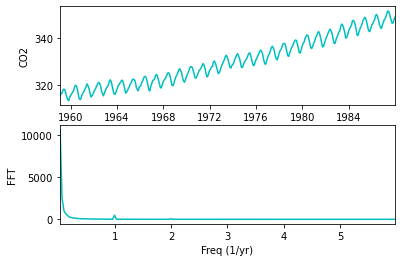

The dot product of STF seasonal and trend components is  (-0+0j)


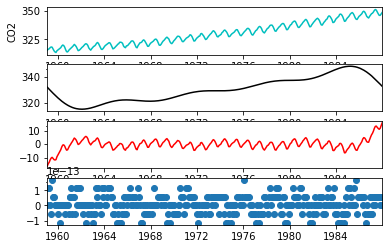

In [195]:
import scipy as scipy
def STF(data, response, freq = 1/12, time_column = "date"):
    data[time_column] = pd.to_datetime(data[time_column], format = '%Y-%m-%d')
    #co2["CO2"] = (co2["CO2"] - statistics.median(co2["CO2"])) * signal.tukey(len(co2))

    dt = freq # yearly freq
    t = np.array(data[time_column])
    f = np.array(data[response])



    n = len(t)
    #Compute FFT
    fhat = np.fft.fft(f, n)
    # Power Spectrum
    PSD = fhat * np.conj(fhat) / n
    # X axis of freqs
    freq = (1 / (dt*n)) * np.arange(n)
    # Plotting first half
    L = np.arange(1, np.floor(n/2), dtype = 'int')

    fig, axes = plt.subplots(2, 1)

    plt.sca(axes[0])
    plt.plot(t, f, color = 'c', LineWidth = 1.5)
    plt.xlim(t[0], t[-1])
    plt.xlabel("Year")
    plt.ylabel(str(response))
    plt.sca(axes[1])
    plt.plot(freq[L], PSD[L], color = 'c')
    plt.xlim(freq[L[0]], freq[L[-1]])
    plt.xlabel("Freq (1/yr)")
    plt.ylabel("FFT")
    plt.show()



    # Use the PSD to filter out noise
    # Filter out freqs with low power
    peaks = int(np.quantile(PSD, 0.975))
    indices = PSD > peaks
    # Zero out small Fourier coefs
    fhat_clean = indices * fhat
    # Inverse FFT for filtered time signal
    ffilt = np.fft.ifft(fhat_clean)


    # Filter out freqs with high power
    indices_seasonal = PSD <= peaks
    fhat_seasonal = indices_seasonal * fhat
    ffilt_seasonal = np.fft.ifft(fhat_seasonal)
    print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))


    fig, axes = plt.subplots(4, 1)
    plt.sca(axes[0])
    plt.plot(t, f, color = 'c')
    plt.xlim(t[0], t[-1])
    plt.xlabel("Year")
    plt.ylabel(response)


    plt.sca(axes[1])
    plt.plot(t, ffilt, color = 'k')
    plt.xlim(t[0], t[-1])


    plt.sca(axes[2])
    plt.plot(t, ffilt_seasonal, color = "red")
    plt.xlim(t[0], t[-1])


    # Find the residuals 
    residuals = data[response] - ffilt_seasonal - ffilt
    plt.sca(axes[3])
    plt.scatter(t, residuals)
    plt.xlim(t[0], t[-1])

    plt.show()

        
# Try new STF function on co2 data
STF(co2, "CO2")
    

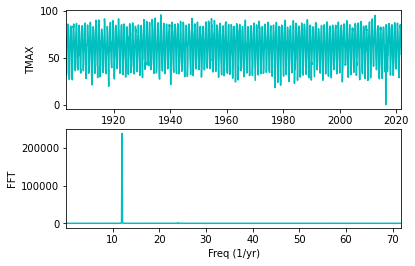

The dot product of STF seasonal and trend components is  0j


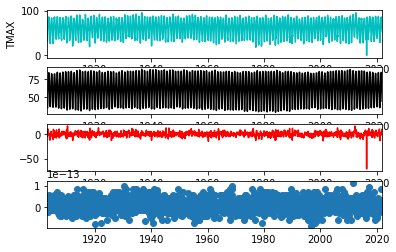

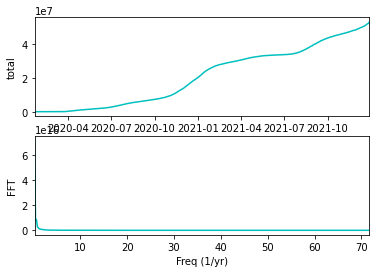

The dot product of STF seasonal and trend components is  (631061656922012-0j)


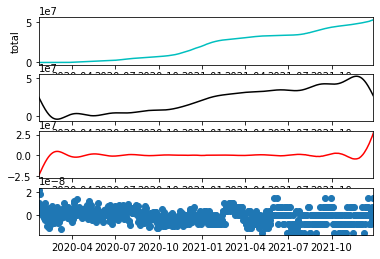

In [152]:
# Load in daily temperature data from station USC00118740
champaignTemp = pd.read_csv('../data/champaign_temps.csv', index_col='date', parse_dates=True, squeeze=True)
#champaignTemp["date"] = pd.to_datetime(champaignTemp["date"], format = '%Y-%m-%d')
# Aggregate to find average max and min temperatures by month
champaignTemp = champaignTemp.resample('M').mean()
#champaignTemp["date"] = champaignTemp.reset_index(inplace = True)
#STF(champaignTemp, "TMIN")
champaignTemp = champaignTemp.reset_index()

champaignTemp = champaignTemp.fillna(0)
STF(champaignTemp, "TMAX", freq = 1/144)


# Data cleaning
covid = pd.read_csv('../data/time_series_covid19_confirmed_US.csv', parse_dates=True, squeeze=True)
covid_dates = covid.iloc[:, 11:]
covid_dates = covid_dates.T
covid_dates["total"] = covid_dates.sum(axis=1)
covid_dates.index = pd.to_datetime(covid_dates.index, format = '%m/%d/%y')
covid_dates = covid_dates.reset_index()

covid_dates["date"] = covid_dates["index"]
STF(covid_dates, "total", freq = 1/144)

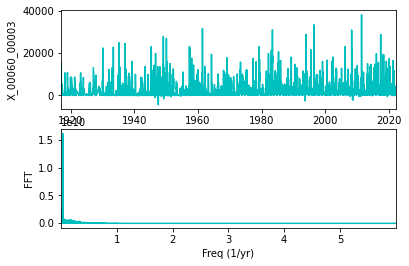

The dot product of STF seasonal and trend components is  (-0+0j)


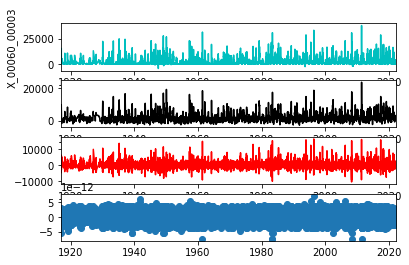

In [178]:
streamflow = pd.read_csv("../data/big_muddy_streamflow.csv", parse_dates=True)
STF(streamflow, response = "X_00060_00003", time_column="Date")

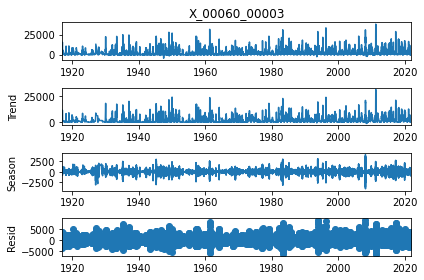

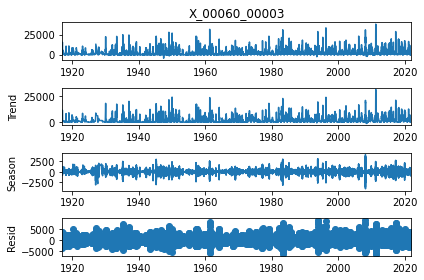

In [176]:
streamflow = pd.read_csv("../data/big_muddy_streamflow.csv", index_col="Date", parse_dates=True)
stl = STL(streamflow["X_00060_00003"], period = 12)
stl.fit().plot()
